In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import widgets
from google.colab import files

#@title Rocket parameters
#@markdown These units are all in inches

nose_diameter = 6.2  #@param {type:"number"}
nose_length = 35.4 #@param {type:"number"}
body_diameter = 6.2  #@param {type:"number"}
body_length = 60 #@param {type:"number"}
boattail_length = 0 #@param {type:"number"}
boattail_diameter = 0 #@param {type:"number"}

In [0]:
#@title  { display-mode: "code" }
# This model is valid up to 18km and above the equator and outputs are in metric units
# usage:
# altitude = 0
# atmosphere = Atmosphere(altitude)
# atmosphere.density
# atmosphere.updateAltitude(10000)
# atmosphere.density
class Atmosphere:
  
  sea_pressure = 101.325 * math.pow(10, 3) # Pa
  sea_temperature = 288.15 # K
  lapse_rate = 0.0065 # K/m
  grav_accel = 9.80665 # m/s/s
  gas_constant = 8.31447 # J/mol/K
  molar_mass = 0.0289644 # kg/mol
  # for sutherland
  c1 = 1.458 * math.pow(10, -6)
  s = 110.4
  
  def __init__(self, altitude):
    self.altitude = altitude
    self.density = None
    self.dyn_viscosity = None
    self.kin_viscosity = None
    self.temperature = self.sea_temperature
    self.pressure = self.sea_pressure
        
    self.updateAltitude(altitude)
    
  def updateAltitude(self, altitude):
    self.altitude = altitude
    self.temperature = self.__calculateTemperature()
    self.pressure = self.__calculatePressure()
    self.density = self.__calculateDensity()
    self.dyn_viscosity = self.__calculateDynViscosity()
    self.kin_viscosity = self.dyn_viscosity/self.density
    
  # https://en.wikipedia.org/wiki/Density_of_air#Altitude 
  def __calculateTemperature(self):
    return self.sea_temperature - (self.lapse_rate * self.altitude)
  
  # https://en.wikipedia.org/wiki/Density_of_air#Altitude  
  def __calculatePressure(self):
    return self.sea_pressure * math.pow(\
        (1 - (self.lapse_rate * self.altitude)/self.sea_temperature),\
        (self.grav_accel * self.molar_mass)/(self.gas_constant * self.lapse_rate)\
    )
  
  # https://en.wikipedia.org/wiki/Density_of_air#Altitude
  def __calculateDensity(self):
    return (self.pressure * self.molar_mass)/(self.gas_constant * self.temperature)
  
  # https://www.cfd-online.com/Wiki/Sutherland%27s_law
  def __calculateDynViscosity(self):
    return (self.c1 * math.pow(self.temperature, 3.0/2.0)) / (self.temperature + self.s)

In [0]:
# method shown in tactical missile design p.31
# this assumes a turbulent boundary layer so it will be not valid for low Re
# units of length and diameter are in inches
# units of density are in kg/m**3, weird but i handle the unit conversion
# isPowered is either True/False and says if the motor is on
def c_do_body_fromMissile(mach, speedOfSound, density, isPowered,\
                          body_length, nose_length, boattail_length,\
                          body_diameter, nose_diameter, boattail_diameter):
  
  # change to handle approx zero machs too
  if mach == 0:
    return (0, 0, 0, 0)
  
  V = mach * speedOfSound
  total_length = body_length + nose_length + boattail_length
  q = (1.0/2.0) * density * V**2
  q_psf = q * 0.020885434273039 # Pascals to psf  
  c_do_body_friction_missile = 0.053 * (total_length / body_diameter) * math.pow((mach/(q_psf * total_length / 12)), 0.2)
  if (mach >= 1.0):
    c_do_body_wave_missile = (1.586 + 1.834/(mach**2)) * math.pow(math.atan(0.5/(nose_length/nose_diameter)), 1.69)
    c_do_body_base_missile = 0.25/mach
  else:
    c_do_body_wave_missile = 0
    c_do_body_base_missile = 0.12 + 0.13 * mach**2

    c_do_body_missile = c_do_body_friction_missile + c_do_body_wave_missile + c_do_body_base_missile
  
  return (c_do_body_missile, c_do_body_friction_missile, c_do_body_wave_missile, c_do_body_base_missile)

In [0]:
M = np.linspace(0.01, 2.5, 250)
V = np.zeros(len(M))
c_do_body_missile = np.zeros(len(M))
c_do_body_friction_missile = np.zeros(len(M))
c_do_body_wave_missile = np.zeros(len(M))
c_do_body_base_missile = np.zeros(len(M))

c_do_body_box = np.zeros(len(M))
c_do_base_box = np.zeros(len(M))
c_do_total_box = np.zeros(len(M))
c_f_box = np.zeros(len(M))

reynolds = np.zeros(len(M))
psf = np.zeros(len(M))

atmosphere = Atmosphere(15000/3.281)

Re_crit = 5.0 * math.pow(10, 5)
gamma = 1.4
R = 287 # J/kgK
density = 1.1315 # kg/m^3
a = math.sqrt(gamma * R * atmosphere.temperature)

for i in range (len(M)):
  c_do_body_missile[i], c_do_body_friction_missile[i],\
  c_do_body_wave_missile[i], c_do_body_base_missile[i] = c_do_body_fromMissile(M[i], a, atmosphere.density, False,\
                                                                               body_length, nose_length, boattail_length,\
                                                                               body_diameter, nose_diameter, boattail_diameter)
    


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

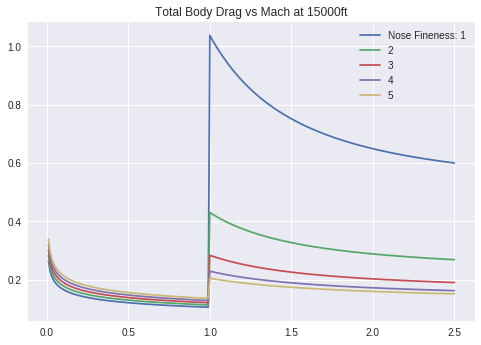

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

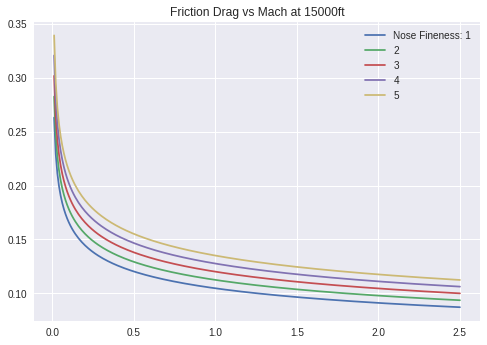

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

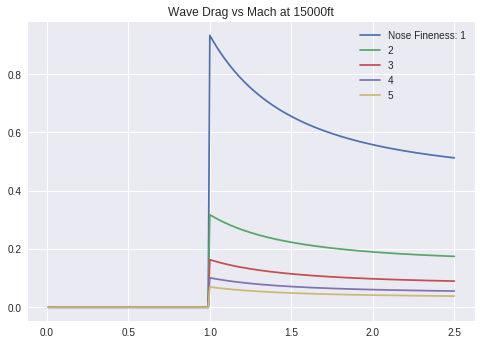

<IPython.core.display.Javascript object>

In [0]:
waveDragCoefficients = []
frictionDragCoefficients = []
bodyDragCoefficients = []
totalDragCoefficients = []
for i in range(0, 5):
  waveDragCoefficients.append(np.zeros(len(M)))
  frictionDragCoefficients.append(np.zeros(len(M)))
  bodyDragCoefficients.append(np.zeros(len(M)))
  totalDragCoefficients.append(np.zeros(len(M)))

for i in range(0, 5):
  for j in range(len(M)):
    totalDragCoefficients[i][j], frictionDragCoefficients[i][j],\
    waveDragCoefficients[i][j], bodyDragCoefficients[i][j] = c_do_body_fromMissile(M[j], a, atmosphere.density, False,\
                                                                             body_length, nose_diameter*(i+1), boattail_length,\
                                                                             body_diameter, nose_diameter, boattail_diameter)  
  
t = widgets.TabBar(["Total Body Drag", "Friction Drag", "Wave Drag"])
with t.output_to(0):
  plt.plot(M, totalDragCoefficients[0], M, totalDragCoefficients[1], M, totalDragCoefficients[2], M, totalDragCoefficients[3], M, totalDragCoefficients[4],)
  plt.title('Total Body Drag vs Mach at 15000ft')
  plt.legend(('Nose Fineness: 1', '2', '3', '4', '5'))
  plt.savefig("Total Body Drag vs Mach at 15000ft.png")
  plt.show()
  
with t.output_to(1):
  plt.plot(M, frictionDragCoefficients[0], M, frictionDragCoefficients[1], M, frictionDragCoefficients[2], M, frictionDragCoefficients[3], M, frictionDragCoefficients[4],)
  plt.title('Friction Drag vs Mach at 15000ft')
  plt.legend(('Nose Fineness: 1', '2', '3', '4', '5'))
  plt.savefig("Friction Drag vs Mach at 15000ft.png")
  plt.show()
  
with t.output_to(2):
  plt.plot(M, waveDragCoefficients[0], M, waveDragCoefficients[1], M, waveDragCoefficients[2], M, waveDragCoefficients[3], M, waveDragCoefficients[4],)
  plt.title('Wave Drag vs Mach at 15000ft')
  plt.legend(('Nose Fineness: 1', '2', '3', '4', '5'))
  plt.savefig("Wave Drag vs Mach at 15000ft.png")
  plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

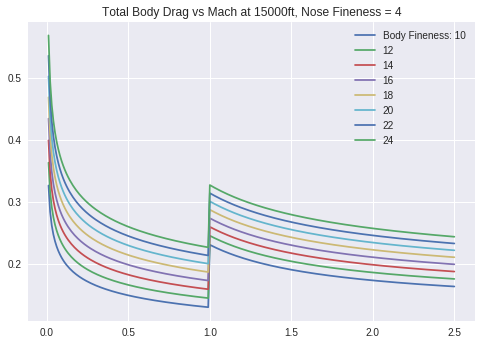

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

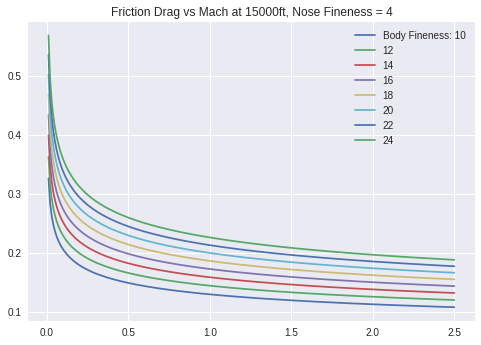

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

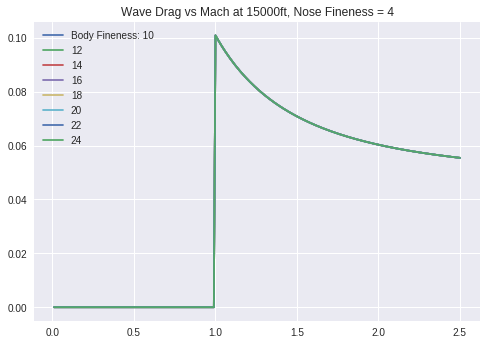

<IPython.core.display.Javascript object>

In [0]:
waveDragCoefficients = []
frictionDragCoefficients = []
bodyDragCoefficients = []
totalDragCoefficients = []
bodyFineness = [10, 12, 14, 16, 18, 20, 22, 24]
for i in range(len(bodyFineness)):
  waveDragCoefficients.append(np.zeros(len(M)))
  frictionDragCoefficients.append(np.zeros(len(M)))
  bodyDragCoefficients.append(np.zeros(len(M)))
  totalDragCoefficients.append(np.zeros(len(M)))

  
for i in range(len(bodyFineness)):
  for j in range(len(M)):
    totalDragCoefficients[i][j], frictionDragCoefficients[i][j],\
    waveDragCoefficients[i][j], bodyDragCoefficients[i][j] = c_do_body_fromMissile(M[j], a, atmosphere.density, False,\
                                                                             body_diameter*bodyFineness[i], nose_diameter*4, boattail_length,\
                                                                             body_diameter, nose_diameter, boattail_diameter)  

t = widgets.TabBar(["Total Body Drag", "Friction Drag", "Wave Drag"])
with t.output_to(0):
  plt.title('Total Body Drag vs Mach at 15000ft, Nose Fineness = 4')
  for i in range(len(bodyFineness)):
    plt.plot(M, totalDragCoefficients[i])
  plt.legend(('Body Fineness: 10', '12', '14', '16', '18', '20', '22', '24'))
  plt.savefig("Total Body Drag vs Mach at 15000ft, Nose Fineness = 4.png")
  plt.show()
  
with t.output_to(1):
  plt.title('Friction Drag vs Mach at 15000ft, Nose Fineness = 4')
  for i in range(len(bodyFineness)):
    plt.plot(M, frictionDragCoefficients[i])
  plt.legend(('Body Fineness: 10', '12', '14', '16', '18', '20', '22', '24'))
  plt.savefig("Friction Drag vs Mach at 15000ft, Nose Fineness = 4.png")
  plt.show()
  
with t.output_to(2):
  plt.title('Wave Drag vs Mach at 15000ft, Nose Fineness = 4')
  for i in range(len(bodyFineness)):
    plt.plot(M, waveDragCoefficients[i])
  plt.legend(('Body Fineness: 10', '12', '14', '16', '18', '20', '22', '24'))
  plt.savefig("Wave Drag vs Mach at 15000ft, Nose Fineness = 4.png")
  plt.show()

In [0]:
#plt.plot(M, c_do_body_friction_missile, M, c_do_body_wave_missile, M, c_do_body_base_missile)
#plt.legend(('c_do_body_friction_missile', 'c_do_body_wave_missile', 'c_do_body_base_missile'))
#plt.show()

#plt.plot(M, c_do_body_missile, M, c_do_body_box)
#plt.legend(('c_do_body_missile', 'c_do_body_box'))
#plt.show()

#plt.plot(M, psf)
#plt.legend('q (psf)')
#plt.show()

In [0]:
# method shown in Box. et al
# convert to metric units
body_length /= 39.37 # inches to meters
body_diameter /= 39.37
boattail_length /= 39.37
nose_length /= 39.37
boattail_diameter /= 39.37
boattail_length /= 39.37

total_length = body_length + nose_length + boattail_length

for i in range (len(M)):
  V[i] = a * M[i]
  Re = V[i] * total_length / atmosphere.kin_viscosity
  
  if Re < Re_crit:
    c_f_box[i] = 1.328/math.sqrt(Re)
  else:
    beta = Re_crit * (0.074/math.pow(Re, 1.0/5.0) - 1.328/math.sqrt(Re))
    c_f_box[i] = 0.074/math.pow(Re, 1.0/5.0) - beta/Re
    
  c_do_body_box[i] = (1 + 60.0/math.pow(total_length/body_diameter, 3.0) + 0.0025 * (body_length/body_diameter))\
    * (2.7*(nose_length/body_diameter) + 4*(body_length/body_diameter) + 2*(1-boattail_diameter/body_diameter)*(boattail_length/body_diameter))\
    * c_f_box[i]
  
  c_do_base_box[i] = 0.029 * math.pow(body_diameter/boattail_diameter, 3) / math.sqrt(c_do_body_box[i])
  
  if M[i] >= 1.1:
    c_do_body_box[i] /= math.sqrt(M[i]**2-1)
    c_do_base_box[i] /= math.sqrt(M[i]**2-1)
  elif M[i] <= 0.8:
    c_do_body_box[i] /= math.sqrt(1 - M[i]**2)
    c_do_base_box[i] /= math.sqrt(1 - M[i]**2)
  elif 0.8 < M[i] < 1.1:
    c_do_body_box[i] /= math.sqrt(1 - 0.8**2)
    c_do_base_box[i] /= math.sqrt(1 - 0.8**2)
    
  c_do_total_box[i] = c_do_body_box[i] + c_do_base_box[i]

ZeroDivisionError: ignored